# Exploratory Data Analysis: Lichess database

This jupyter notebook contains an exploratory data analysis done over a chess database with information from 200k games. Each game (the rows of the data frame) contains categorical variates, such as the type of opening (ECO), and numerical variates, such as the elo of each player.

(Tentative) The main objective of this EDA was to determine regularities in the playstyle and how these changed when variates, such as elo, changed. Furthermore, the analysis includes general statistics calculations including location, scale, and shape parameters (mean value, variance, skewness, and kurtosis) which helped draw conclusions from a set of hypothesis tests.

### Remarks

1. In general, the notebook has the following structure: markdown cell --> code cells. 

2. Each code cell includes hashed text explaining briefly what the code is supposed to be doing. Additional commentary is contained in the markdown cells.

3. All the required libraries are included in the first code cell, namely the preamble of the notebook. Exceptions include particular ```scipy``` submodules used for miscellaneous statistics calculations.

4. Recurrent code is included in the ```functions.py``` module.

5. All the pertinent references are in the ```README.md``` file.

6. **All the graphs** contained in this notebook are saved in the ```graphs``` directory.

7. The dataset is available in the github repository as ```modified_dataset```.

In [155]:
# Preamble
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import functions as f

In [156]:
# Loading dataset
games_df = pd.read_csv('modified_dataset', delimiter = ',')
games_df.drop('index', inplace = True, axis = 1)
games_df

,BlackElo,BlackRatingDiff,Date,ECO,Result,Termination,UTCTime,WhiteElo,WhiteRatingDiff,BlackTitle,WhiteTitle,Category,Weekday,Movements
0,906,13.0,2019.04.30,B15,0-1,Normal,22:00:24,971,-12.0,NaN,NaN,Blitz,Tuesday,73
1,1296,28.0,2019.04.30,C50,0-1,Normal,22:00:13,1312,-10.0,NaN,NaN,Blitz,Tuesday,67
2,1761,-13.0,2019.04.30,C41,1-0,Normal,22:00:41,1653,27.0,NaN,NaN,Rapid,Tuesday,71
3,2404,8.0,2019.04.30,B06,0-1,Normal,22:00:43,2324,-8.0,NaN,FM,Bullet,Tuesday,85
4,1595,-10.0,2019.04.30,B32,1-0,Normal,22:00:46,1614,29.0,NaN,NaN,Blitz,Tuesday,71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,1491,10.0,2019.05.22,B00,0-1,Normal,21:17:00,1456,-9.0,NaN,NaN,Rapid,Wednesday,30
199996,1549,-10.0,2019.05.22,C21,1-0,Time forfeit,21:17:09,1575,25.0,NaN,NaN,Classical,Wednesday,59
199997,1450,-11.0,2019.05.22,D20,1-0,Normal,21:17:09,1439,11.0,NaN,NaN,Blitz,Wednesday,42
199998,1588,40.0,2019.05.22,B07,0-1,Normal,21:17:13,1753,-18.0,NaN,NaN,Bullet,Wednesday,45


## Goodness of fit test for Elo distribution

$H_0$: Average Elo data is beta distributed.

$H_1$: Average Elo data deviaties from a beta distribution.

In [157]:
from scipy import stats
from functools import partial

avg_elo = (games_df['WhiteElo'] + games_df['BlackElo'])/2 # Calculates average elo of each game
data = avg_elo
beta_param_bounds = [(4,5),(7,9),(600, 700),(2400,2500)] # Prepares bounds for the a, b, loc, and scale parameters of the beta fit.
fit_result = stats.fit(stats.beta, data, beta_param_bounds) # Gives results of the fit
a, b, loc, scale = fit_result.params 
beta_fit = stats.beta(a, b, loc, scale) # Distribution that fits the data best

In [158]:
# Kolmogorov - Smirnov test
D, p_value = stats.kstest(data, partial(stats.beta.cdf, a = a, b = b, loc = loc, scale = scale))
print('Maximum function difference (KS test statistic): {}'.format(D))
print('p value: {}'.format(p_value))
alpha = 0.05
if p_value < alpha:
    print('The null hypothesis is rejected.')
else:
    print('The null hypothesis is not rejected.')

Maximum function difference (KS test statistic): 0.01908934910025567
p value: 9.70772480647905e-64
The null hypothesis is rejected.


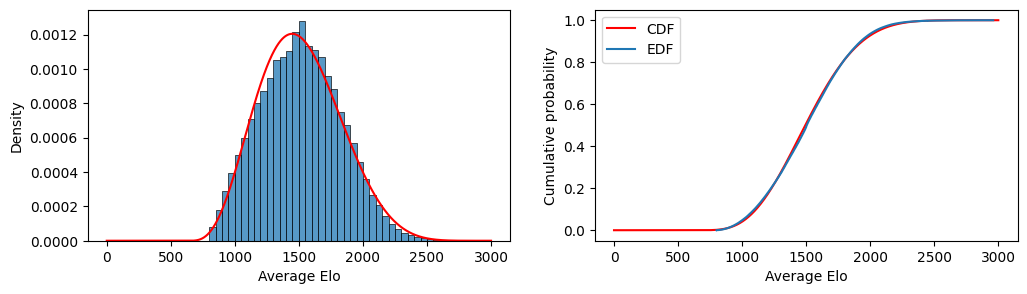

In [159]:
fig, axes = plt.subplots(1, 2, figsize = (12, 3)) # Definition of graphing instances

x = np.linspace(0, 3000, 10000) # Graphing range

pdf = beta_fit.pdf(x) # Probability density function
cdf = beta_fit.cdf(x) # Cumulative distribution function

axes[0].plot(x, pdf, color = 'r', label = 'Fit') # Graphs PDF
sns.histplot(data, ax = axes[0], stat = 'density',binwidth = 50, label = 'Data') # Graphs histogram of data

N = 2e5 # Number of games
sorted_data = np.sort(data) # Ordered data
edf = np.arange(N) / float(N) # 'Experimental' cumulative distribution function

axes[1].plot(x, cdf, color = 'r', label = 'CDF') # Graphs CDF
axes[1].plot(sorted_data, edf, label = 'EDF') # Graphs EDF

for ax in axes.flat:
    ax.set(xlabel = 'Average Elo')

axes[1].set(ylabel = 'Cumulative probability')
plt.legend()
fig.savefig('graphs/kstest-avg_elo', dpi = 700, format = 'pdf', bbox_inches = 'tight')

## ANOVA test: Win rate and opening

Each game is grouped in one of five categories according to the first letter of ECO.

$H_0$: The mean win rate for each of the groups is the same.

$H_1$: At least one group has a different mean win rate.

## ANOVA test: Win rate and time of the day

Each game is grouped in one of ??? groups according to UTCTime.

$H_0$: The mean win rate is the same at any time of the day.

$H_1$: The mean win rate is higher for a certain time of the day.

## Chi-Squere test: Win rate and Elo range

Each game is classified in one of 4 tiers of elo according to the mean elo between black and white: low elo, mid elo, high elo, very high elo.

$H_0$: There is no substantial relationship between the EloTier variable and Result variable

$H_1$: There is a substantial relationship between the EloTier variable and Result variable

In [160]:
import scipy.stats
from sklearn.utils import resample
from scipy.stats import bootstrap
from scipy.stats import chi2_contingency

games_df['EloTier'] = ['Very high elo' if elo >= 2000 else 'High elo' if elo >= 1800 else \
    'Mid elo' if elo >= 1400 else 'Low elo' for elo in avg_elo] #Create a new EloTier column
games_df['Result'].replace({'0-1': 'Lose', '1/2-1/2': 'Draw', '*': np.NAN, '1-0': 'Win'}, inplace = True) #Replace the numeric with categorical variables
games_df

,BlackElo,BlackRatingDiff,Date,ECO,Result,Termination,UTCTime,WhiteElo,WhiteRatingDiff,BlackTitle,WhiteTitle,Category,Weekday,Movements,EloTier
0,906,13.0,2019.04.30,B15,Lose,Normal,22:00:24,971,-12.0,NaN,NaN,Blitz,Tuesday,73,Low elo
1,1296,28.0,2019.04.30,C50,Lose,Normal,22:00:13,1312,-10.0,NaN,NaN,Blitz,Tuesday,67,Low elo
2,1761,-13.0,2019.04.30,C41,Win,Normal,22:00:41,1653,27.0,NaN,NaN,Rapid,Tuesday,71,Mid elo
3,2404,8.0,2019.04.30,B06,Lose,Normal,22:00:43,2324,-8.0,NaN,FM,Bullet,Tuesday,85,Very high elo
4,1595,-10.0,2019.04.30,B32,Win,Normal,22:00:46,1614,29.0,NaN,NaN,Blitz,Tuesday,71,Mid elo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,1491,10.0,2019.05.22,B00,Lose,Normal,21:17:00,1456,-9.0,NaN,NaN,Rapid,Wednesday,30,Mid elo
199996,1549,-10.0,2019.05.22,C21,Win,Time forfeit,21:17:09,1575,25.0,NaN,NaN,Classical,Wednesday,59,Mid elo
199997,1450,-11.0,2019.05.22,D20,Win,Normal,21:17:09,1439,11.0,NaN,NaN,Blitz,Wednesday,42,Mid elo
199998,1588,40.0,2019.05.22,B07,Lose,Normal,21:17:13,1753,-18.0,NaN,NaN,Bullet,Wednesday,45,Mid elo


The Abandoned variable was removed because its occurrence in the data was only 5

EloTier        Result
Mid elo        Win       44080
               Lose      41227
Low elo        Win       37623
               Lose      36022
High elo       Win       12248
               Lose      11356
Very high elo  Win        6400
               Lose       5894
Mid elo        Draw       2247
Low elo        Draw       1341
High elo       Draw        903
Very high elo  Draw        654
dtype: int64

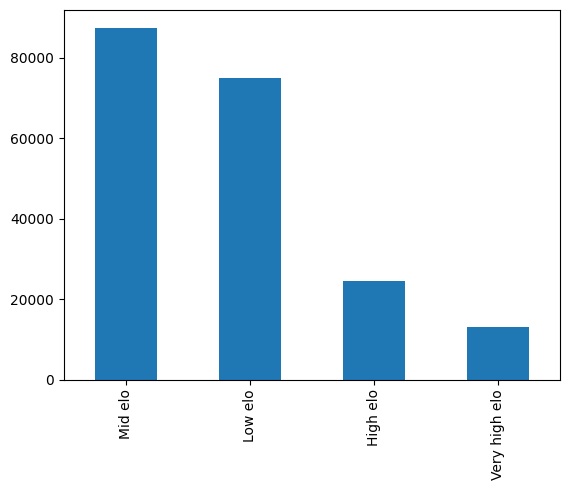

In [161]:
regames_df = pd.DataFrame(games_df['EloTier'])
regames_df['Result'] = games_df['Result']
regames_df['EloTier'].value_counts().plot.bar()
regames_df.value_counts() 

As can be seen from the count histogram above, the data is imbalanced. In order to correct this, the groups will be downsampled to 1875 observations each.

In [162]:
# Individual dataframes for each group
df_L = regames_df[(regames_df['EloTier'] == 'Low elo')]
df_M = regames_df[(regames_df['EloTier'] == 'Mid elo')]
df_H = regames_df[(regames_df['EloTier'] == 'High elo')]
df_VH = regames_df[(regames_df['EloTier'] == 'Very high elo')]


# Resampling
re_L = resample(df_L, replace = True, n_samples = 1875, random_state = 32158)
re_M = resample(df_M, replace = True, n_samples = 1875, random_state = 32158)
re_H = resample(df_H, replace = True, n_samples = 1875, random_state = 32158)
re_VH = resample(df_VH, replace = True, n_samples = 1875, random_state = 32158)

# Resampled group dataframe
re_regames = pd.concat([re_L, re_M, re_H, re_VH])
re_regames = re_regames.reset_index(drop = True)
re_regames


,EloTier,Result
0,Low elo,Lose
1,Low elo,Win
2,Low elo,Lose
3,Low elo,Lose
4,Low elo,Win
...,...,...
7495,Very high elo,Lose
7496,Very high elo,Lose
7497,Very high elo,Win
7498,Very high elo,Lose


<AxesSubplot:xlabel='Result', ylabel='Density'>

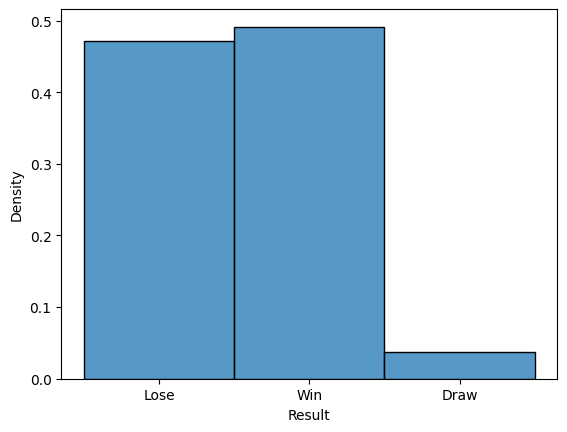

In [163]:
sns.histplot(re_regames['Result'], stat = 'density')

In [164]:
contingency_games = pd.crosstab(re_regames["EloTier"], re_regames["Result"]) #contingency table
contingency_games

#chi_2 test
chi2_stat, p, dof, expected = scipy.stats.chi2_contingency(contingency_games)
print(f"chi2 statistic:     {chi2_stat:.5g}")
print(f"p-value:            {p:.5g}")
print(f"degrees of freedom: {dof}")
print("expected frequencies:\n",expected)
if p < alpha:
    print('The null hypothesis is rejected.')
else:
    print('The null hypothesis is not rejected.')

chi2 statistic:     16.013
p-value:            0.013683
degrees of freedom: 6
expected frequencies:
 [[ 69.25923456 884.11788238 921.62288305]
 [ 69.25923456 884.11788238 921.62288305]
 [ 69.25923456 884.11788238 921.62288305]
 [ 69.22229631 883.64635285 921.13135085]]
The null hypothesis is rejected.


## ANOVA test: Result and RatingDiff

Each game is classified in one of the three groups of the variable Result with its respective WhiteRatingDiff value

The WhiteRatingDiff is used since the BlackRatingDiff is the counterpart of the WhiteRatingDiff

WhiteRateDiffs with a negative value are assumed to have a higher probability of being associated with a game loss, on the other hand WhiteRateDiffs with a positive value have a higher probability of being associated with a game win.

$H_0$: There is no substantial relationship between the WhiteRatingDiff variable and Result variable

$H_1$: There is a substantial relationship between the WhiteRatingDiff variable and Result variable

Result  WhiteRatingDiff
Lose    -10.0              18033
        -11.0              15061
Win      10.0              13937
         11.0              13878
Lose    -9.0               12109
                           ...  
        -250.0                 1
        -249.0                 1
        -248.0                 1
        -247.0                 1
Win      692.0                 1
Length: 764, dtype: int64

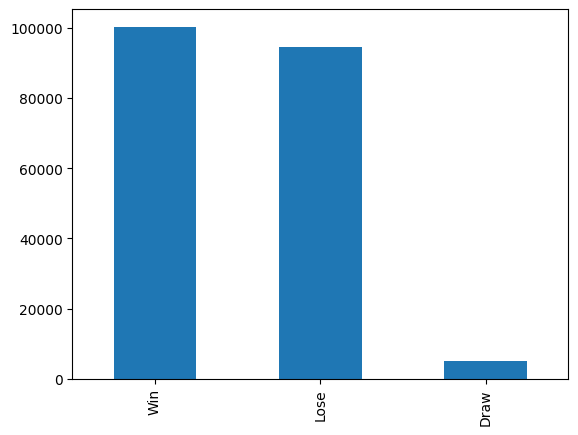

In [165]:
games_WRD = pd.DataFrame(games_df['Result'])
games_WRD['WhiteRatingDiff'] = games_df['WhiteRatingDiff']
games_WRD['Result'].value_counts().plot.bar()
games_WRD.value_counts()

In [166]:
# Individual dataframes for each group
df_Lose = games_WRD[(games_WRD['Result'] == 'Lose')].dropna()
df_Win = games_WRD[(games_WRD['Result'] == 'Win')].dropna()
df_Draw = games_WRD[(games_WRD['Result'] == 'Draw')].dropna()

# Resampling
re_Lose = resample(df_Lose, replace = True, n_samples = 2500, random_state = 58963)
re_Win = resample(df_Win, replace = True, n_samples = 2500, random_state = 58963)
re_Draw = resample(df_Draw, replace = True, n_samples = 2500, random_state = 58963)


# Resampled group dataframe
re_games_WRD = pd.concat([re_Lose, re_Win, re_Draw])
re_games_WRD = re_games_WRD.reset_index(drop = True)
re_games_WRD

,Result,WhiteRatingDiff
0,Lose,-11.0
1,Lose,-15.0
2,Lose,-14.0
3,Lose,-10.0
4,Lose,-10.0
...,...,...
7495,Draw,0.0
7496,Draw,-1.0
7497,Draw,-2.0
7498,Draw,1.0


<AxesSubplot:xlabel='WhiteRatingDiff', ylabel='Density'>

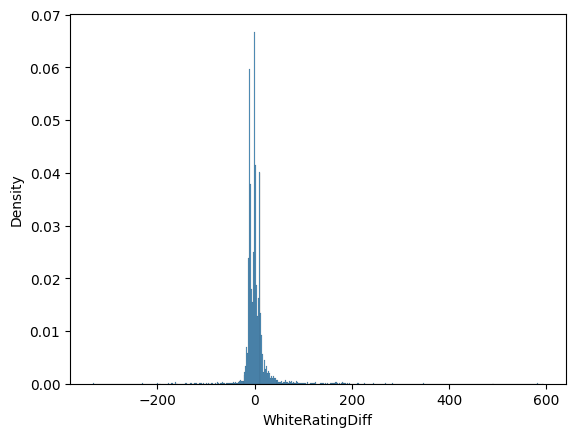

In [167]:
sns.histplot(re_games_WRD['WhiteRatingDiff'], stat = 'density')

In [168]:
# Grouping
groups = re_games_WRD.groupby('Result').groups
Lose = re_games_WRD['WhiteRatingDiff'][groups['Lose']]
Win = re_games_WRD['WhiteRatingDiff'][groups['Win']]
Draw = re_games_WRD['WhiteRatingDiff'][groups['Draw']]

#log transformation
Lose_log = np.log(Lose + 334)
Win_log = np.log(Win + 334)
Draw_log = np.log(Draw + 334)
 
# ANOVA
f_stat, p_value = stats.f_oneway(Lose_log, Win_log, Draw_log)
print('F statistic = {}'.format(f_stat))
print('p-value = {}'.format(p_value))
if p_value < alpha:
    print('The null hypothesis is rejected.')
else:
    print('The null hypothesis is not rejected.')

F statistic = 808.9777309987919
p-value = 7.5145e-319
The null hypothesis is rejected.


## A/B test (Binomial test):


In [169]:
from scipy.stats import binom_test

games_bin = pd.DataFrame(games_df['Result'].replace({ 'Draw': np.NAN }))
games_bin

,Result
0,Lose
1,Lose
2,Win
3,Lose
4,Win
...,...
199995,Lose
199996,Win
199997,Win
199998,Lose


In [223]:

# Resampling
n_samples = 150000
resample_bin = resample(games_bin['Result'], replace = True, n_samples = n_samples, random_state = 60785)


# Resampled dataframe
re_games_bin = resample_bin.reset_index(drop = True)
re_games_bin = pd.DataFrame(re_games_bin)
re_games_bin_count = re_games_bin.value_counts()
re_games_bin_count = pd.DataFrame(re_games_bin_count)
victories = re_games_bin_count.iloc[['0']]
re_games_bin_count


,0
Result,
Win,75515
Lose,70689


<AxesSubplot:xlabel='Result', ylabel='Count'>

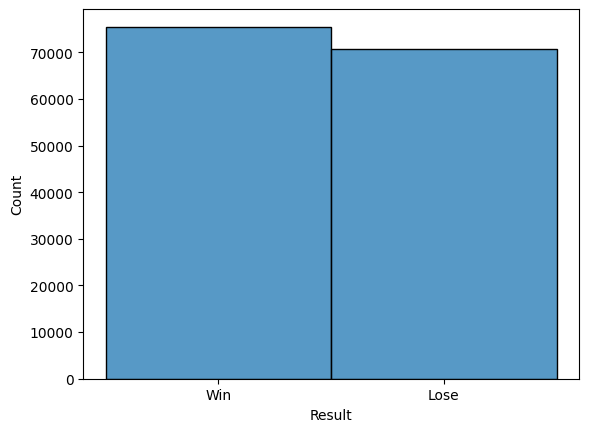

In [219]:
sns.histplot(re_games_bin['Result'])

In [224]:
# Binomial test
p_value = stats.binom_test(x = victories , n=n_samples, p = 1/2, alternative= 'greater')
print('p-value = {}'.format(p_value))
if p_value < alpha:
    print('The null hypothesis is rejected.')
else:
    print('The null hypothesis is not rejected.')


p-value = [0.00394343]
The null hypothesis is rejected.
